In [2]:
%matplotlib inline
import boto3
import botocore
import requests
from dask.distributed import Client, progress
import netCDF4
import xarray as xr
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from IPython.display import Image, display

from botocore import UNSIGNED
from botocore.config import Config

# path to modules
import sys
sys.path.append('../modules')

from GOESR_functions import goes_lat_lon_reproj#, get_s3_keys
from plotter import loadCPT

In [3]:
# set output filepath
outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/goes_images/outputs/'
fig_outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/goes_images/outputs/figures/'
dat_outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/goes_images/outputs/data/'

In [4]:
# Set filepath
datadir_sat = '../outputs/data/'

# set file names
filename_sat = 'GOES16_CMIP_2017_05_22_15-2017_05_24_15'

# open satellite images Dataset object
filepath_sat = datadir_sat + filename_sat
sat = xr.open_dataset(filepath_sat)
print('Opened File:', filepath_sat)

Opened File: ../outputs/data/GOES16_CMIP_2017_05_22_15-2017_05_24_15


In [5]:
# Set filepath
datadir_wrf = '../input_data/'

# set file names
filenames_wrf = ['wrfout_d03_2017-05-22_00:00:00_cloud', 'wrfout_d03_2017-05-23_00:00:00_cloud', 
                'wrfout_d03_2017-05-24_00:00:00_cloud', 'wrfout_d03_2017-05-25_00:00:00_cloud']

da_list = []

for j in range(len(filenames_wrf)):
    
    # open wrf Dataset object
    filepath_wrf = datadir_wrf + filenames_wrf[j]
    dat = xr.open_dataset(filepath_wrf)
    print('Opened File:', filepath_wrf)
    
    # append xarray to a list
    da_list.append(dat)

# convert list of xarrays to one xarray
wrf = xr.concat(da_list, dim = 'time')

Opened File: ../input_data/wrfout_d03_2017-05-22_00:00:00_cloud
Opened File: ../input_data/wrfout_d03_2017-05-23_00:00:00_cloud
Opened File: ../input_data/wrfout_d03_2017-05-24_00:00:00_cloud
Opened File: ../input_data/wrfout_d03_2017-05-25_00:00:00_cloud


In [82]:
# sum/mean coud variables with z
wrf['CLDFRA_sum'] = wrf['CLDFRA'].sum(dim = 'z')
wrf['CLDFRA_mean'] = wrf['CLDFRA'].mean(dim = 'z')
wrf['QCLOUD_sum'] = wrf['QCLOUD'].sum(dim = 'z')

In [8]:
# round sat time data to nearest hour to line up with wrf data
times = []

for t in sat.t.values:

    t = datetime.strptime(str(t), '%Y-%m-%dT%H:%M:%S.000000000')
    
    times.append(t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))
    
sat['t'] = times

In [71]:
bounds = [wrf.lon.min().values, wrf.lon.max().values, wrf.lat.min().values, wrf.lat.max().values]

# crop the goes data to my extent im interested in
sat['CMI_trim'] = sat['CMI'].where((sat.lats >= bounds[2]) & (sat.lats <= bounds[3]) & (sat.lons >= bounds[0]) & (sat.lons <= bounds[1]), drop = True)

In [89]:
def goes_n_wrf(data1, data2, data_units, data_name, data_cols, data_titles, width, height, bounds, \
               levels, lat_labels, lon_labels, outdir):

    # set map projection
    mapcrs = ccrs.PlateCarree() # mapcrs - what want in
    datacrs = ccrs.PlateCarree() # datacrs - what comes in
        
    # save lats and lons
    lons1 = data1['lons'].values
    lats1 = data1['lats'].values 
            
    lons2 = data2['lon'].values
    lats2 = data2['lat'].values     
        
    # create figure
    fig = plt.figure(figsize = (width, height))
    gs = plt.GridSpec(1, 2, figure = fig)

    
    for i in range(2):
        ################## add plot axes 
        ax = fig.add_subplot(gs[0,i], projection=mapcrs)

        # set plot boundaries
        ax.set_extent(bounds, crs=mapcrs)

        # add map features
        ax.add_feature(cfeature.NaturalEarthFeature(category='physical', scale='10m', facecolor='none', name='coastline'),\
                       edgecolor='black', linewidth = 1.5)

        # subtitles
        ax.set_title(str(data2.time.values)[0:16].replace("T"," "), loc = 'right')        
        
        # Add lat lon labels
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlines = False
        gl.ylines = False
        gl.xlocator = mticker.FixedLocator(lon_labels)
        gl.ylocator = mticker.FixedLocator(lat_labels)
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        # add title for all of subplots
        ax.set_title(data_titles[i], fontsize = 16, y = 1.1, x = 0.53)
                
        if (i == 0):
            # data magntiude (contour filled) 
            cf = ax.contourf(lons1, lats1, data1, transform = datacrs, cmap = data_cols, extend = 'both', levels = levels[i])

            cb = plt.colorbar(cf, orientation = 'vertical', shrink = 0.95, pad = 0.006, label = data_units[i])

        elif (i == 1):
            # data magntiude (contour filled) 
            cf = ax.contourf(lons2, lats2, data2, transform = datacrs, cmap = data_cols, extend = 'both', levels = levels[i])

            cb = plt.colorbar(cf, orientation = 'vertical', shrink = 0.95, pad = 0.006, label = data_units[i])
    
    
    # Display figure
    # save file name as start datetime end datetime and variable
    plot_name = data_name + '_' + str(data2.time.values)[0:13].replace("T","_") + '.png'

    plt.savefig(outdir+plot_name,  bbox_inches='tight', dpi = 120)
    plt.show()
    print('File saved as:', outdir+plot_name, '\n')

/home/sbarc/students/coello/miniconda3/envs/goes/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/sbarc/students/coello/miniconda3/envs/goes/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


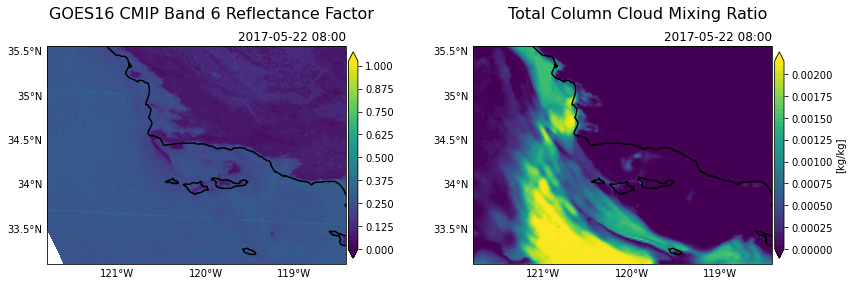

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/goes_images/outputs/figures/goes16_cmip_band2_n_q_cloud_2017-05-22_08.png 



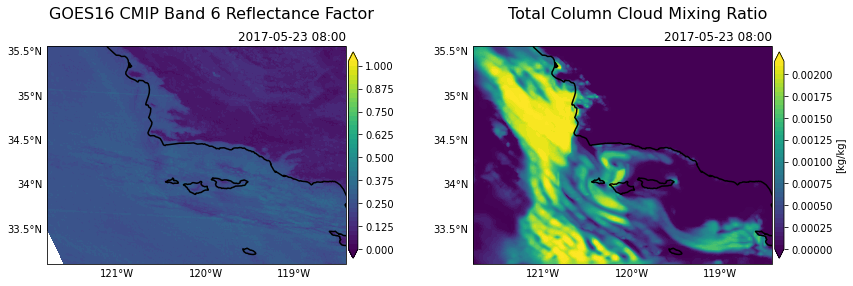

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/goes_images/outputs/figures/goes16_cmip_band2_n_q_cloud_2017-05-23_08.png 



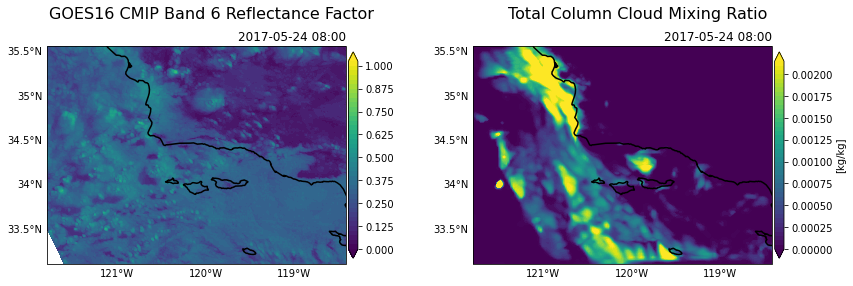

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/goes_images/outputs/figures/goes16_cmip_band2_n_q_cloud_2017-05-24_08.png 



In [84]:
for i in range(len(sat.t)):

    goes_n_wrf(sat['CMI_trim'].sel(t = str(sat.t.values[i])), \
                   wrf['QCLOUD_sum'].sel(time = str(sat.t.values[i])), \
                   ['', '[kg/kg]'], 'goes16_cmip_band2_n_q_cloud', 'viridis',\
                   ['GOES16 CMIP Band 6 Reflectance Factor', 'Total Column Cloud Mixing Ratio'], 14, 4, bounds, \
                   [np.arange(0, 1.05, 0.025), np.arange(0, 0.0022, 0.00005)],\
                   np.arange(31.5, 36, 0.5), np.arange(-118.0, -122, -1), fig_outdir)

In [93]:
wrf['CLDFRA'].max()

<xarray.DataArray 'CLDFRA' ()>
array(1.)

/home/sbarc/students/coello/miniconda3/envs/goes/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/sbarc/students/coello/miniconda3/envs/goes/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


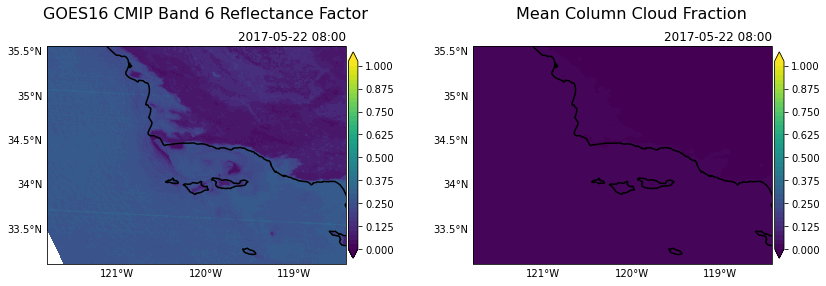

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/goes_images/outputs/figures/goes16_cmip_band2_n_cld_frac_2017-05-22_08.png 



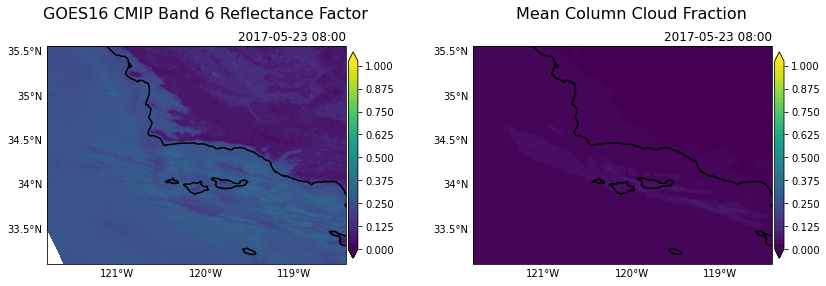

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/goes_images/outputs/figures/goes16_cmip_band2_n_cld_frac_2017-05-23_08.png 



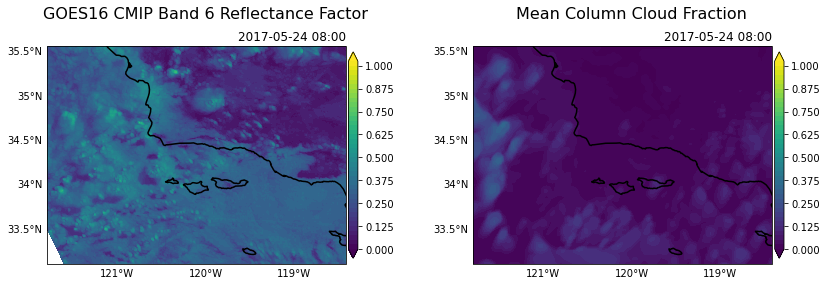

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/goes_images/outputs/figures/goes16_cmip_band2_n_cld_frac_2017-05-24_08.png 



In [92]:
for i in range(len(sat.t)):

    goes_n_wrf(sat['CMI_trim'].sel(t = str(sat.t.values[i])), \
                   wrf['CLDFRA_mean'].sel(time = str(sat.t.values[i])), \
                   ['', ''], 'goes16_cmip_band2_n_cld_frac', 'viridis',\
                   ['GOES16 CMIP Band 6 Reflectance Factor', 'Mean Column Cloud Fraction'], 14, 4, bounds, \
                   [np.arange(0, 1.05, 0.025), np.arange(0, 1.05, 0.025)],\
                   np.arange(31.5, 36, 0.5), np.arange(-118.0, -122, -1), fig_outdir)